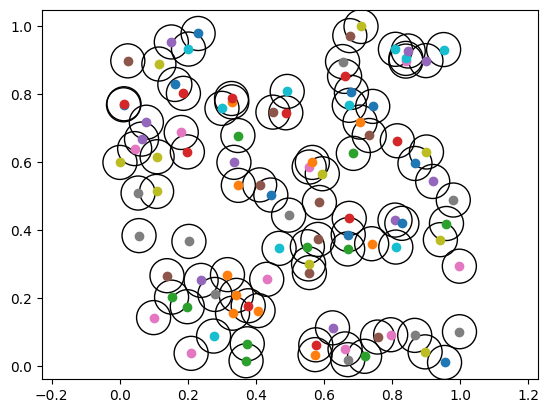

0.0008959000115282834


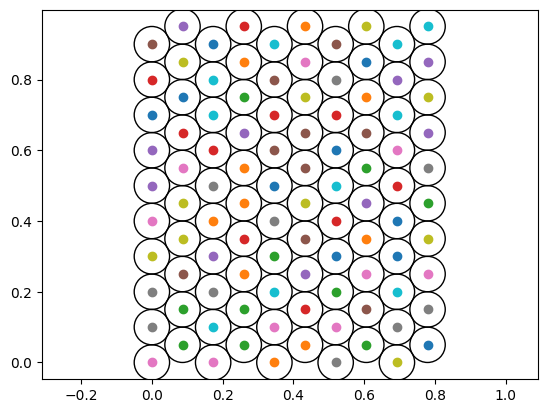

In [1]:
import time
from typing import List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
import scipy.optimize
import scipy.sparse
from networkx.drawing.layout import _process_params
from tqdm.auto import tqdm

from src.python.cost import calcCost
from src.python.vis.visGraph import visGraph


# https://www.redblobgames.com/grids/hexagons/


def toHexagon(pos: np.ndarray, k: float) -> np.ndarray:
    if len(pos) == 0:
        return pos
    n = len(pos)
    sqrtN = int(np.sqrt(n))
    pos[np.argsort(pos[:, 0]), 0] = np.repeat(np.arange(n // sqrtN + 1), sqrtN)[:n]
    lastYs = np.arange(n % sqrtN) + (sqrtN - n % sqrtN) // 2
    ys = np.concat([np.tile(np.arange(sqrtN), n // sqrtN), lastYs])
    pos[np.lexsort((pos[:, 1], pos[:, 0])), 1] = ys
    pos[:, 1] = (pos[:, 1] + (pos[:, 0] % 2) * 0.5) * k
    pos[:, 0] *= 1.5 / pow(3, 0.5) * k
    return pos


def drawHexagon(pos: np.ndarray, k: float):
    for v in pos:
        plt.plot(v[0], v[1], "o")
        circle = plt.Circle(v, k / 2, color="k", fill=False)
        plt.gca().add_artist(circle)
    plt.axis("equal")
    plt.show()


# for n in range(100):
n = 100
k = 1 / np.sqrt(n)
pos = np.random.rand(n, 2)
drawHexagon(pos, k)
t0 = time.perf_counter()
pos = toHexagon(pos, k)
print(time.perf_counter() - t0)
drawHexagon(pos, k)

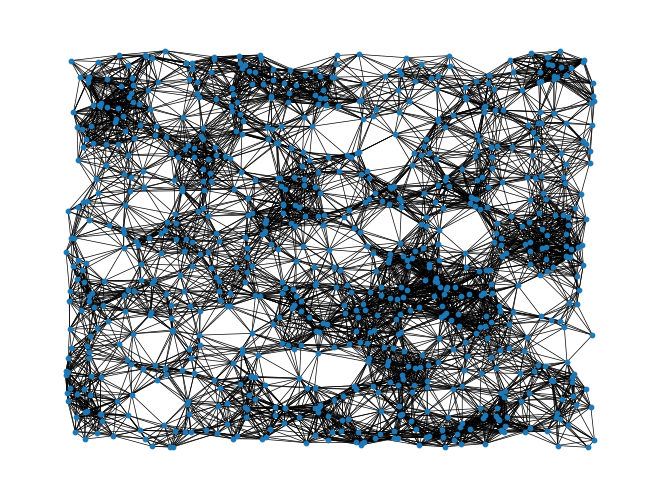

In [2]:
G = nx.random_geometric_graph(800, 0.1, seed=0)
# G = nx.circular_ladder_graph(500)

pos = np.array([G.nodes[i]["pos"] for i in G.nodes])
nx.draw(G, pos, node_size=10, width=0.5)
plt.show()

dim = 2
G, center = _process_params(G, None, dim)

A = nx.to_scipy_sparse_array(G, dtype="f")
n = G.number_of_nodes()
k = 1 / np.sqrt(n)
A = scipy.sparse.coo_matrix(A)
assert np.all(A.data >= 0)

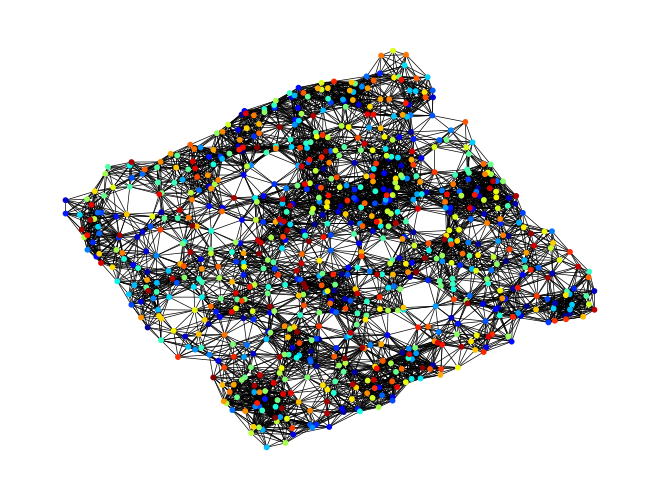

In [3]:
pos = nx.kamada_kawai_layout(G)
visGraph(G, pos, node_size=10, width=0.5)

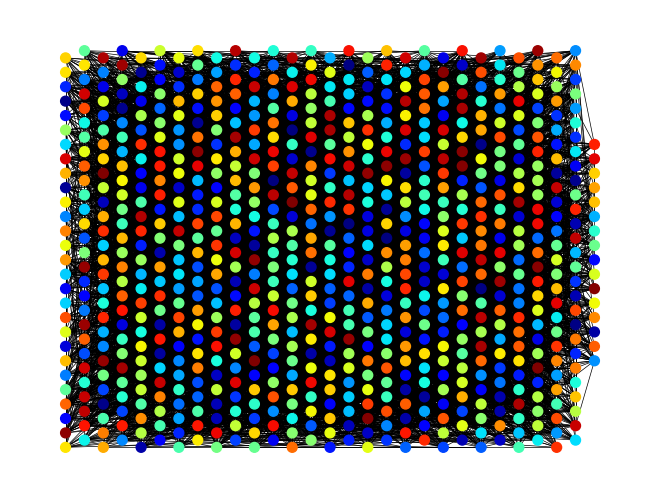

  0%|          | 0/1 [00:00<?, ?it/s]

t1-t0=0.030414999986533076
start: spring_layout
end: spring_layout


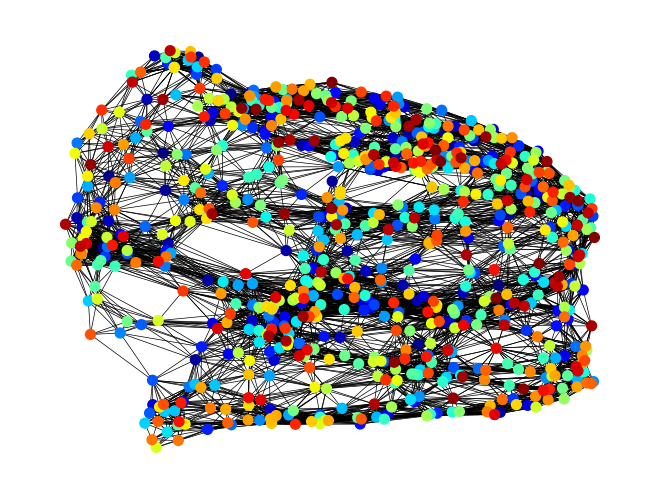

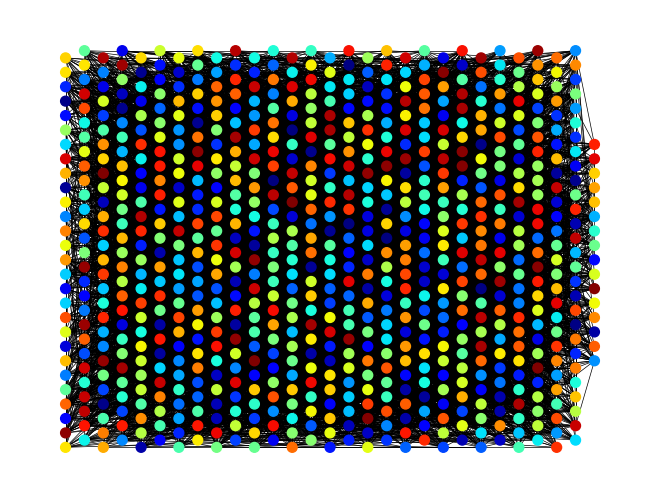

  0%|          | 0/1000 [00:00<?, ?it/s]

t1-t0=5.964491499995347
start: spring_layout
end: spring_layout


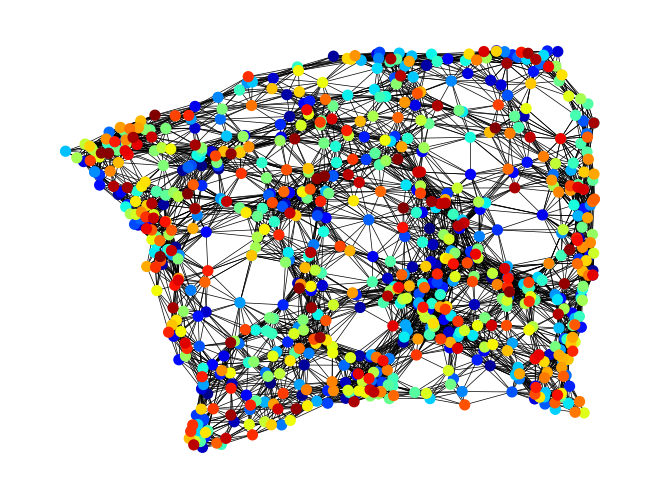

In [5]:
for iterations in [1, 1000]:
    np.random.seed(0)
    pos = toHexagon(np.random.rand(n, 2), k)
    visGraph(G, pos)

    temp = 0.3
    dt = temp / iterations
    hist = []
    t0 = time.perf_counter()
    pos = toHexagon(pos, k)
    for nit in tqdm(range(iterations)):
        delta = pos[A.row] - pos[A.col]
        distance = np.linalg.norm(delta, axis=1)
        displacement = np.zeros((n, dim))
        np.add.at(displacement, A.row, (-A.data * distance / k)[:, np.newaxis] * delta)
        displacement /= np.linalg.norm(displacement, axis=1)[:, np.newaxis] + 0.01 * k
        displacement *= temp
        old_pos = pos.copy() if nit % 50 == 0 else None
        pos = toHexagon(pos + displacement, k)
        if nit % 50 == 0 and np.allclose(old_pos, pos):
            break
        if nit % 100 == 0:
            hist.append(pos.copy())
        temp -= dt
    hist.append(pos.copy())
    t1 = time.perf_counter()
    print(f"{t1-t0=}")

    # for pos_hist in hist:
    #     visGraph(G, pos_hist)

    print("start: spring_layout")
    pos = nx.spring_layout(G, seed=0, pos={i: pos[i] for i in range(n)})
    print("end: spring_layout")

    visGraph(G, pos, node_size=10, width=0.5)

In [ ]:
A = A.tolil()


def cost_fun(x):
    EPS = 1e-10
    pos = x.reshape((n, dim))
    grad = np.zeros((n, dim))
    cost = 0.0
    for i in range(n):
        Ai = A.getrow(i).toarray().flatten()
        delta = pos[i] - pos
        assert np.all(delta[i] == 0.0)
        distance = np.linalg.norm(delta, axis=1)
        cost += np.sum(Ai * distance**3 / (3 * k) - (k**2) * np.log(distance + EPS))
        distance = np.where(distance < 0.01, 0.01, distance)
        distance_inv = 1 / distance
        coefficient1 = Ai * distance / k - (k * distance_inv) ** 2
        grad[i] = coefficient1 @ delta
    # print(f"{cost=}")
    return cost, grad.ravel()


pos_hist = []
res = sp.optimize.minimize(
    cost_fun,
    pos.ravel(),
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 30, "disp": True},
    callback=lambda x: pos_hist.append((x.reshape((n, dim)))),
)

print("!")
for pos in pos_hist:
    visGraph(G, pos)

pos = np.random.rand(n, 2)
pos_hist = []
res = sp.optimize.minimize(
    cost_fun,
    pos.ravel(),
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 30, "disp": True},
    callback=lambda x: pos_hist.append((x.reshape((n, dim)))),
)

print("!")
for pos in pos_hist:
    visGraph(G, pos)